In [23]:
import instaseis
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import obspy
from obspy.imaging.beachball import beach,beachball
from obspy.taup import TauPyModel
%matplotlib inline

### Initialize an instaseis database

In [24]:
db = instaseis.open_db("./databases/20s_PREM_ANI_FORCES")
print db

ReciprocalInstaseisDB reciprocal Green's function Database (v7) generated with these parameters:
	components           : vertical and horizontal
	velocity model       : prem_ani
	attenuation          : True
	dominant period      : 20.000 s
	dump type            : displ_only
	excitation type      : dipole
	time step            : 4.869 s
	sampling rate        : 0.205 Hz
	number of samples    : 370
	seismogram length    : 1796.8 s
	source time function : errorf
	source shift         : 34.085 s
	spatial order        : 4
	min/max radius       : 5700.0 - 6371.0 km
	Planet radius        : 6371.0 km
	min/max distance     : 0.0 - 180.0 deg
	time stepping scheme : newmark2
	compiler/user        : gfortran 4.9.1 by lion on dhcp-10-181-12-69.dynamic.eduroam.mwn.de
	directory/url        : databases/20s_PREM_ANI_FORCES
	size of netCDF files : 598.2 MB
	generated by AxiSEM version 60945ec at 2014-10-23T15:35:34.000000Z



### Windowing function

In [25]:
prem = TauPyModel('prem')
def window_stream(stream,source,receiver,phase,t_start,t_end,taup_model):
    phase_arrs = taup_model.get_travel_times_geo(source_depth_in_km=source.depth_in_m/1000.0, 
                                                 source_latitude_in_deg=source.latitude,
                                                 source_longitude_in_deg=source.longitude, 
                                                 receiver_latitude_in_deg=receiver.latitude,
                                                 receiver_longitude_in_deg=receiver.longitude,
                                                 phase_list=[phase])
    arr = phase_arrs[0]
    st_new = obspy.Stream()
    for tr in stream:
        starttime = tr.stats.starttime + arr.time + t_start
        endtime = tr.stats.starttime + arr.time + t_end
        windowed_tr = tr.slice(starttime=starttime,endtime=endtime)
        st_new += windowed_tr
        
    return st_new.resample(1.0)
    

### Sample moment tensor inversion with a single station (using synthetic data)

In this example, we will invert for earthquake source parameters (and uncertainties) using a test event with a known moment tensor solution. We will invert for the point source MT solution of the 2011 Virginia event, recorded at station US.AAM in Ann Arbor, MI. We will first perform the inversion using synthetic waveforms from the 'known' MT solution.

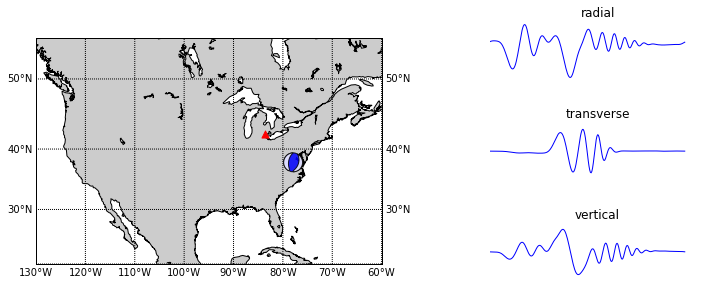

In [26]:
#define 'true' source parameters
m_rr_true = 4.710000e+24
m_tt_true = 3.810000e+22
m_pp_true = -4.740000e+24
m_rt_true = 3.990000e+23
m_rp_true = -8.050000e+23
m_tp_true = -1.230000e+24
lon_true = -77.93
lat_true = 37.91
depth_true = 12000.
mt_true = [m_rr_true,m_tt_true,m_pp_true,
           m_rt_true,m_rp_true,m_tp_true]

#get seismograms
rec_lon = -83.66
rec_lat = 42.3 
receiver = instaseis.Receiver(
    latitude=rec_lat, longitude=rec_lon, network="US", station="AAM")
source_true = instaseis.Source(
    latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
    m_rr = m_rr_true / 1E7,
    m_tt = m_tt_true / 1E7,
    m_pp = m_pp_true / 1E7,
    m_rt = m_rt_true / 1E7,
    m_rp = m_rp_true / 1E7,
    m_tp = m_tp_true / 1E7,
    origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
st = db.get_seismograms(source=source_true, receiver=receiver,components='RTZ',kind='displacement')

#window seismograms
st_true = window_stream(stream=st,source=source_true,
                        receiver=receiver,phase='P',
                        t_start=-20.0,t_end=250.0,
                        taup_model=prem)


#plot map and 'true' (synthetic) data
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-130.,llcrnrlat=20.,urcrnrlon=-60.,urcrnrlat=55.,\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(np.arange(10,90,10),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,10),labels=[1,1,0,1])
x, y = m(lon_true, lat_true)
#ax = plt.gca()
b = beach(mt_true, xy=(x, y), width=400000, linewidth=1, alpha=0.85)
b.set_zorder(10)
ax.add_collection(b)
x, y = m(rec_lon, rec_lat)
ax.scatter(x,y,marker='^',color='r',s=50,zorder=99)

#plot_waveforms
#radial
ax_r=fig.add_axes([1.15,0.75,0.5,0.2])
ax_r.plot(st_true[0].data)
ax_r.set_title('radial')
ax_r.set_axis_off()
ax_t=fig.add_axes([1.15,0.4,0.5,0.2])
ax_t.plot(st_true[1].data)
ax_t.set_title('transverse')
ax_t.set_axis_off()
ax_z=fig.add_axes([1.15,0.05,0.5,0.2])
ax_z.plot(st_true[2].data)
ax_z.set_title('vertical')
ax_z.set_axis_off()
plt.show()

### Model parameterization
As in Mustac and Tkalcic (2016), we parameterize the MT solution $\mathbf{M}$ as a sum of six elementary moment tensors. Additionally,
there are 3 location parameters, lon, lat, and depth. The origin time is assumed to be known exactly.

$
\mathbf{M^1} = \begin{matrix} 
               0 & 1 & 0 \\
               1 & 0 & 0 \\
               0 & 0 & 0 
               \end{matrix}
$
$\hspace{1cm}$
$
\mathbf{M^2} = \begin{matrix} 
               0 & 0 & 1 \\
               0 & 0 & 0 \\
               1 & 0 & 0 
               \end{matrix}
$
$\hspace{1cm}$
$
\mathbf{M^3} = \begin{matrix} 
               0 & 0 & 0 \\
               0 & 0 & -1 \\
               0 & -1 & 0 
               \end{matrix}
$ 

$
\mathbf{M^4} = \begin{matrix} 
               -1 & 0 & 0 \\
               0 & 0 & 0 \\
               0 & 0 & 1 
               \end{matrix}
$
$\hspace{1cm}$
$
\mathbf{M^5} = \begin{matrix} 
               0 & 0 & 0 \\
               0 & -1 & 0 \\
               0 & 0 & 1 
               \end{matrix}
$
$\hspace{1cm}$
$
\mathbf{M^6} = \begin{matrix} 
               1 & 0 & 0 \\
               0 & 1 & 0 \\
               0 & 0 & 1 
               \end{matrix}
$ 

The full moment tensor can be expressed as a linear combination of each of these elementary moment tensors

$\mathbf{M} = \sum_{n=1}^6 a_n \mathbf{M}^n$

where $a_n$ is the weighting factor.

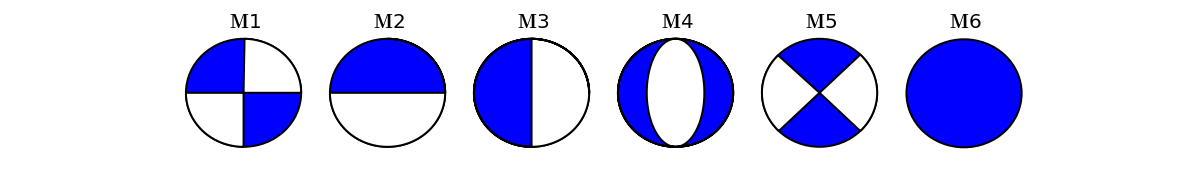

In [27]:
fig = plt.figure(figsize=(16,2.25))
ax = fig.add_axes([0.0,0.0,1.0,1.0])
ax.set_xlim(-0.25,1.75)
ax.set_ylim((-0.05,0.25))

m_elem_list = []
m_1 = [0,0,0,0,0,1]
m_2 = [0,0,0,1,0,0]
m_3 = [0,0,0,0,1,0]
m_4 = [-1,0,1,0,0,0]
m_5 = [0,1,-1,0,0,0]
m_6 = [1,1,1,0,0,0]
m_elem_list = [m_1,m_2,m_3,m_4,m_5,m_6]

for ii,m_elem in enumerate(m_elem_list):
    bb = beach(m_elem,xy=(0.1+ii*0.25, 0.1),width=0.2)
    ax.add_collection(bb)
    ax.text(0.075+ii*0.25,0.22,'$\mathbf{M}$'+str(ii+1),fontsize=20)
ax.set_axis_off()
plt.show()

#Note! obspy beachball is not trustworthy... M5 is clearly incorrect.

### Bayesian inversion

The Bayes mantra is 'the posterior is proportional to the likelyhood times the prior'... i.e., 

$p(\mathbf{m}|\mathbf{d}) \propto p(\mathbf{d}|\mathbf{m}) p(\mathbf{m})$

We will assume a uniform prior.

### Forward model

The forward problem is to generate three component (RTZ) synthetic seismograms for a given proposed moment tensor, and location parameters. The synthetic data must be processed in the same manner as the 'true' data. In our case this means windowing the data around the P arrival.

In [28]:
def forward_model(model_vec, receiver):
    '''
    model_vec:
        model_vec[0] = a_1
        model_vec[1] = a_2
        model_vec[2] = a_3
        model_vec[3] = a_4
        model_vec[4] = a_5
        model_vec[5] = a_6
        model_vec[6] = source longitude
        model_vec[7] = source latitude
        model_vec[8] = source depth (m)
    
    receiver:
        instaseis receiver object
    '''
    source = instaseis.Source(
    #latitude=model_vec[7], longitude=model_vec[6], depth_in_m=model_vec[8],
    latitude=lat_true,longitude=lon_true,depth_in_m=depth_true,
    m_rr = -1.0*model_vec[3] + model_vec[5],
    m_tt = -1.0*model_vec[4] + model_vec[5],
    m_pp = model_vec[3]+model_vec[4]+model_vec[5],
    m_rt = model_vec[0],
    m_rp = model_vec[1],
    m_tp = -1.0*model_vec[2],
    origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
    st_model = db.get_seismograms(source=source, receiver=receiver,components='RTZ',kind='displacement')
    st_model_windowed = window_stream(stream=st_model,source=source,
                               receiver=receiver,phase='P',
                               t_start=-20.0,t_end=250.0,
                               taup_model=prem)
    #print model_vec
    return st_model_windowed
    

### Misfit function

In [29]:
def chi2(st_true,st_model):
    data_vector = np.hstack((st_true[0].data,st_true[1].data,st_true[2].data))
    predicted_data_vector = np.hstack((st_model[0].data,st_model[1].data,st_model[2].data))
    l2_misfit = np.linalg.norm((data_vector - predicted_data_vector)**2)
    #print 'L2 MISFIT',l2_misfit
    return l2_misfit

### Likelihood function 

In [30]:
def likelihood(st_true,st_model):
    return -chi2(st_true,st_model)

### Markov chain

We will perform a sample markov chain, with a 'burn in' period of 100 iterations

In [31]:
chain = []
burn_in = 10000
iter_max = 50000

#initialize a 'random' guess for the moment tensor. For a first test, the location parameters will be correct
lon_test = lon_true
lat_test = lat_true
depth_test = depth_true
model_current = [np.random.rand()*1E17,
                 np.random.rand()*1E17,
                 np.random.rand()*1E17,
                 np.random.rand()*1E17,
                 np.random.rand()*1E17,
                 np.random.rand()*1E17]#,
                 #lon_test,
                 #lat_test,
                 #depth_test]
st_current = forward_model(model_current,receiver)
likelihood_current = likelihood(st_true,st_current)

for i in range(0,iter_max):
    #model_proposed = [model + 0.1*(np.random.rand()-0.5) for model in model_current]
    model_proposed = [model + 1.0e16*(np.random.rand()-0.5) for model in model_current]
    st_proposed = forward_model(model_proposed, receiver)
    likelihood_proposed = likelihood(st_true,st_proposed)
    ratio = np.exp(likelihood_proposed - likelihood_current)
    r = np.random.rand()
    #print 'i {}:'.format(i),ratio,r
    if ratio > r:
        model_current = model_proposed
        likelihood_current = likelihood_proposed
    if i > burn_in:
        chain.append(model_current)
        
print 'DONE'

DONE


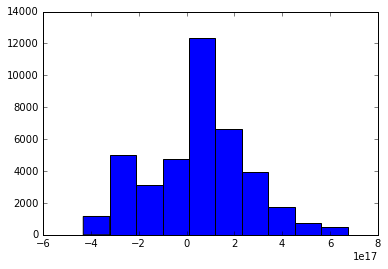

In [51]:
m_1_chain = []
m_2_chain = []
m_3_chain = []
m_4_chain = []
m_5_chain = []
m_6_chain = []
for i in range(0,len(chain)):
    m_1_chain.append(chain[i][0])
    m_2_chain.append(chain[i][1])
    m_3_chain.append(chain[i][2])
    m_4_chain.append(chain[i][3])
    m_5_chain.append(chain[i][4])
    m_6_chain.append(chain[i][5])
plt.hist(m_6_chain)
plt.show()

In [41]:
model_avg = np.average(chain,axis=0)
print model_avg

[  6.50260554e+16   7.56119902e+17   5.91709156e+17   1.06236168e+18
   2.87050323e+17   5.31772053e+16]


In [ ]:
map_1 = 1e17
map_2 = 0.9e18
map_3 = 0.5e18 #0.8e18
map_4 = 1.0e18
map_5 = 4.0e17
map_6 = 0.75e17
MAP = [map_1,map_2,map_3,map_4,map_5,map_6]

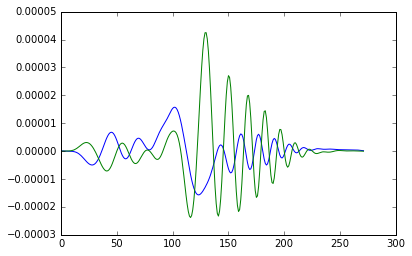

In [44]:
st_best = forward_model(model_avg,receiver)
st_best = forward_model()
plt.plot(st_true[2].data)
plt.plot(st_best[2].data)
plt.show()